In [54]:
import datetime
from calendar_ipynb.google_oauth import verify_credentials
from calendar_ipynb.events import fetch_events, filter_out_future_events, filter_out_past_events, sort_events, handle_overlapping_event_durations, insert_untracked_times, get_primary_timezone, pretty_print_timedelta
from calendar_ipynb.sleep_events import insert_sleep_events
from calendar_ipynb.ipywidgets.calendar_selection import (
    select_calendars,
    get_selected_calendars,
)
from calendar_ipynb.ipywidgets.date_range_selection import get_selected_date_range
from calendar_ipynb.meta import classify_events

%matplotlib widget
%load_ext autoreload
# Automatically reload all modules
%autoreload 2

EMAIL_IDS = ["fahimalizain@gmail.com", "fahim.zain@kwalee.com"]

for email in EMAIL_IDS:
    verify_credentials(email)

INFO:calendar_ipynb.google_oauth:Verifying credentials for fahimalizain@gmail.com
INFO:calendar_ipynb.google_oauth:✅ Credentials found for fahimalizain@gmail.com
INFO:calendar_ipynb.google_oauth:Verifying credentials for fahim.zain@kwalee.com
INFO:calendar_ipynb.google_oauth:✅ Credentials found for fahim.zain@kwalee.com


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
select_calendars(EMAIL_IDS)
selected_calendars = get_selected_calendars()
if not selected_calendars:
    raise ValueError("No calendars selected")

primary_timezone = get_primary_timezone(selected_calendars=selected_calendars)

INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


In [56]:
from_datetime, to_datetime = get_selected_date_range(timezone=primary_timezone)
if not from_datetime or not to_datetime:
    raise ValueError("Please provide from_date and to_date")

print("Date Range:", from_datetime, " TO ", to_datetime, 'in Timezone:', primary_timezone)

Date Range: 2025-04-01 00:00:00+05:30  TO  2025-05-01 23:59:59+05:30 in Timezone: Asia/Kolkata


In [57]:
fetched_events = []
for email, calendars in get_selected_calendars().items():
    for calendar in calendars:
        fetched_events.extend(
            fetch_events(
                email=email,
                calendar_id=calendar,
                from_datetime=from_datetime,
                to_datetime=to_datetime,
            )
        )

INFO:calendar_ipynb.events:Fetching events from 2025-04-01T00:00:00+05:30 to 2025-05-01T23:59:59+05:30for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-04-01T00:00:00+05:30 to 2025-05-01T23:59:59+05:30for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-04-01T00:00:00+05:30 to 2025-05-01T23:59:59+05:30for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-04-01T00:00:00+05:30 to 2025-05-01T23:59:59+05:30for fahimalizain@gmail.com
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events:Fetching events from 2025-04-01T00:00:00+05:30 to 2025-05-01T23:59:59+05:30for fahim.zain@kwalee.

In [58]:
# Process Events
# Make a deep copy of the fetched events to avoid modifying the original list
from copy import deepcopy
events = deepcopy(fetched_events)

print("Total Events Fetched:", len(events))
events = filter_out_future_events(events)
events = filter_out_past_events(from_datetime=from_datetime, events=events)
events = sort_events(events)
events = handle_overlapping_event_durations(events)
events = insert_sleep_events(events)
events = insert_untracked_times(events)
events = classify_events(events)

Total Events Fetched: 1406


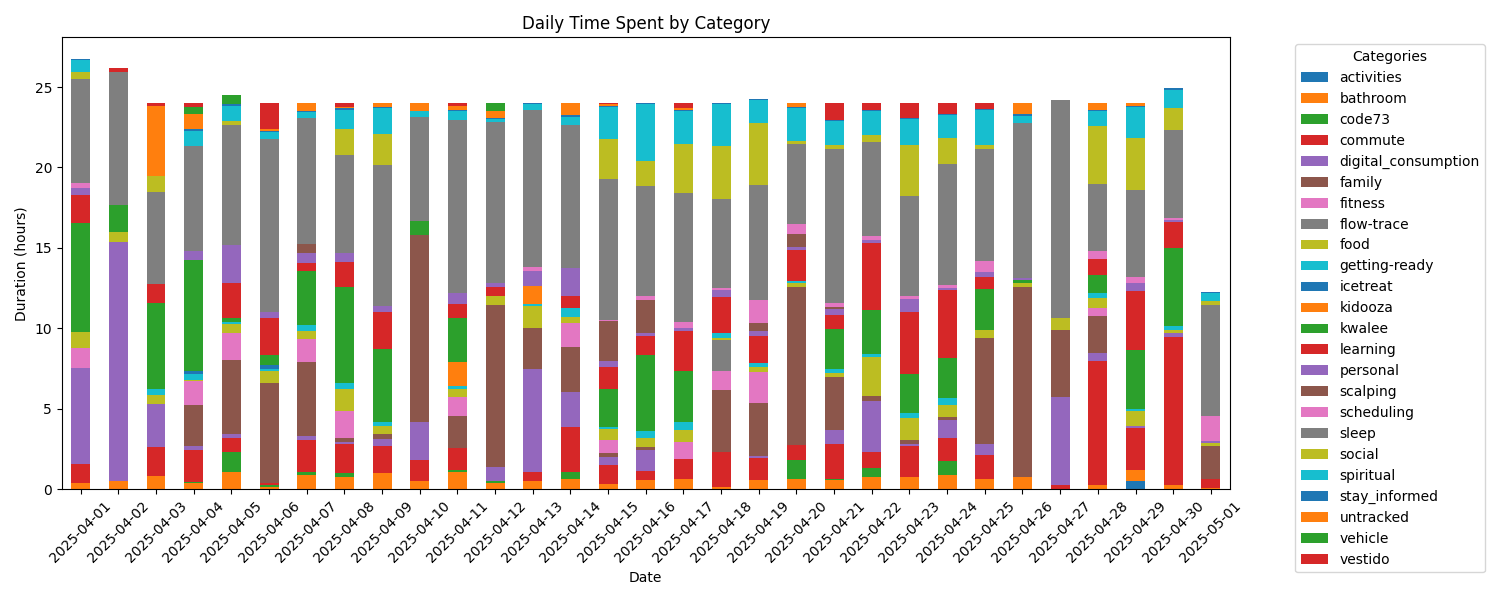

In [59]:
from calendar_ipynb.ipywidgets.bargraph_grouped_by_day import show_bargraph

show_bargraph(events)

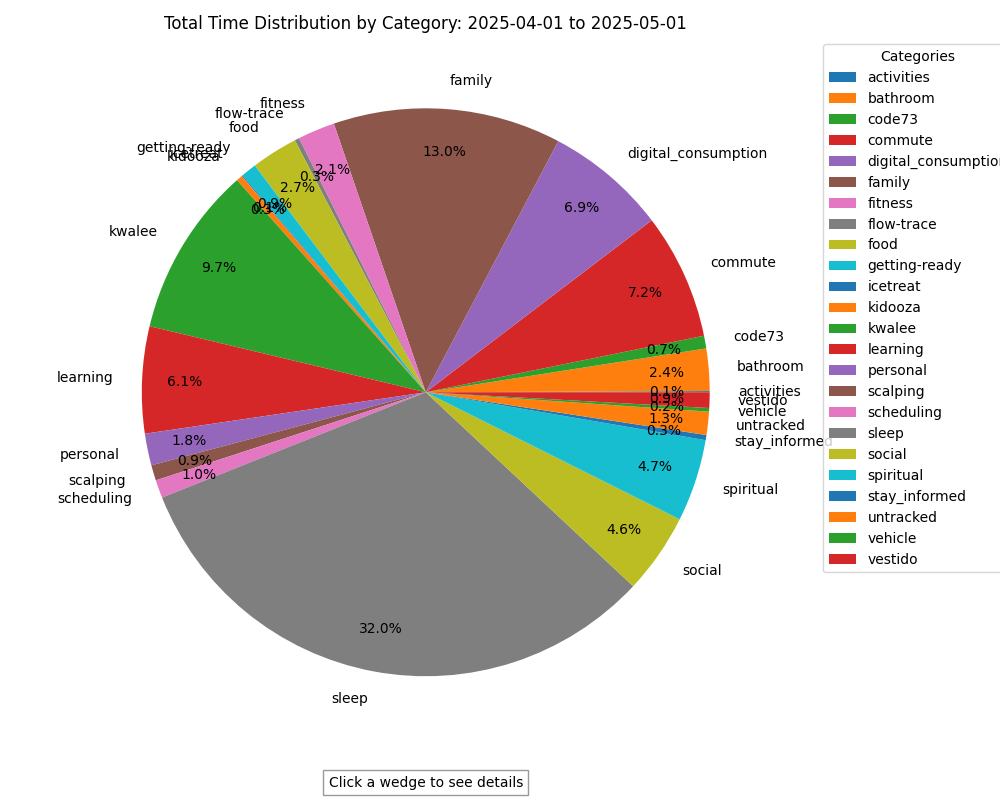

In [60]:
%matplotlib widget
from calendar_ipynb.ipywidgets.piechart import show_piechart

show_piechart(events)

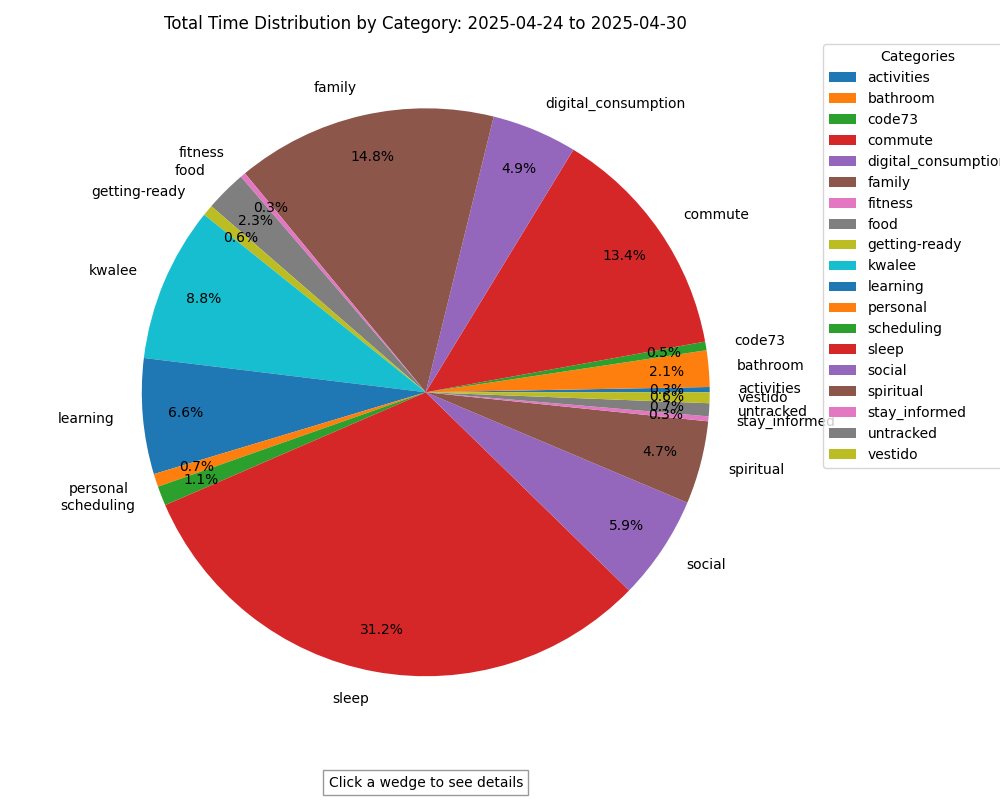

In [61]:
yesterday = datetime.date.today() - datetime.timedelta(days=1)
_7d_ago = yesterday - datetime.timedelta(days=6)
_7d_events = [
    event for event in events
    if datetime.datetime.fromisoformat(event["start"]["dateTime"]).date() >= _7d_ago
    and datetime.datetime.fromisoformat(event["start"]["dateTime"]).date() <= yesterday
]
_today_events = [event for event in events if datetime.datetime.fromisoformat(event["start"]["dateTime"]).date() == datetime.date.today()]

_events = _7d_events
# _events = _today_events
show_piechart(_events)


In [63]:
# This cell is to debug the sleep calculation logic
# First, we check for 30th April and 1st May

def get_events_for_date(date_str: str):
    global events
    _date = datetime.datetime.fromisoformat(f"{date_str}T00:00:00+05:30")
    filtered_events = [
        event for event in events
        if datetime.datetime.fromisoformat(event["start"]["dateTime"]) >= _date
        and datetime.datetime.fromisoformat(event["start"]["dateTime"]).date() <= _date.date()
    ]
    
    return filtered_events

def pretty_print_events(title: str, events: list):
    print(title)
    for event in events:
        time_str = ""
        start_datetime = datetime.datetime.fromisoformat(event["start"]["dateTime"])
        end_datetime = datetime.datetime.fromisoformat(event["end"]["dateTime"])

        time_str += f"{start_datetime.strftime('%H:%M')} - {end_datetime.strftime('%H:%M')}"
        time_str += f" / {pretty_print_timedelta(end_datetime - start_datetime)}"   # {end_datetime.date().strftime('%d %b')}

        print(" ", time_str, " | ", event['summary'])

def summarize_sleep(date_str: str):
    global events
    filtered_events = get_events_for_date(date_str)

    if not len(filtered_events):
        print("No events found for this date")
        return

    sleep_events = [
        event for event in filtered_events
        if any(x[0] == "sleep" for x in event["categories"])
    ]

    pretty_print_events(f"Sleep Events on {date_str}", sleep_events)

    sleep_total_min = sum(x["duration_min"] for x in sleep_events)
    tdelta = datetime.timedelta(minutes=sleep_total_min)
    print("Total Sleep:", pretty_print_timedelta(tdelta), "\n\n")

pretty_print_events("All Events on 2025-04-01", get_events_for_date("2025-04-01"))
summarize_sleep(date_str="2025-04-01")

All Events on 2025-04-01
  00:00 - 05:15 / 5h 15m  |  Sleeping
  00:00 - 01:00 / 1h  |  Twitter | Social Media
  01:15 - 01:30 / 15m  |  Asleep
  05:15 - 05:30 / 15m  |  Woke Up
  05:15 - 05:30 / 15m  |  PGI to CRLM | Commute
  05:30 - 05:50 / 20m  |  CRLM to Kwalee | Commute
  05:50 - 06:05 / 15m  |  Bathroom
  06:05 - 06:15 / 10m  |  Fresh Up
  06:15 - 06:30 / 15m  |  Prayer: Subah
  06:30 - 06:50 / 20m  |  Calendar Check | calendar-ipynb
  06:50 - 07:00 / 10m  |  Check Emails
  06:50 - 07:00 / 10m  |  TENETS Reminder!
  07:00 - 07:20 / 20m  |  Personal Finance
  07:20 - 08:00 / 40m  |  LeetCode | Learning
  08:00 - 08:30 / 30m  |  MinHeap & MaxHeap | Learning
  08:30 - 09:00 / 30m  |  Breakfast
  09:00 - 10:30 / 1h 30m  |  Nimbus: BE API Endpoint Implementation | Almada
  10:30 - 10:40 / 10m  |  Pavan / QA Discussion | Almada
  10:40 - 10:55 / 15m  |  Nimbus: Dependents Endpoints Update | Almada
  10:55 - 11:10 / 15m  |  Nimbus: Disable Aggregator on App and propagate that on Waterf